In [1]:
import os
import random

import numpy as np
import pandas as pd

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    Dropout
)

import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,RocCurveDisplay,classification_report,precision_score,recall_score,f1_score
import time
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [3]:
def matrix_confusion(yt, yp,time_taken):
    data = {'Y_Real': yt,
            'Y_Pred': yp}

    df = pd.DataFrame(data, columns=['Y_Real','Y_Pred'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Pred'], rownames=['Real'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, fmt='g')

    plt.show()
    y_val = df['Y_Real'].to_numpy()
    predictions = df['Y_Pred'].to_numpy()
    accuracy = accuracy_score(y_val,predictions)
    precision = precision_score(y_val,predictions)
    recall = recall_score(y_val,predictions)
    f1 = f1_score(y_val,predictions)
    print('Time taken: ',time_taken)
    print('Test size:',len(y_val))
    print('Total Accuracy: ',accuracy)
    print('Total Precision: ',precision)
    print('Total Recall: ',recall)
    print('Total F1 Score: ',f1)
    print("Classification Report:\n")
    print(classification_report(y_val,predictions))


    return time_taken,accuracy,precision,recall,f1

In [4]:
torch.cuda.is_available()

True

In [5]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

In [6]:
train_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/train', transform=transform)
test_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/test', transform=transform)
valid_data = torchvision.datasets.ImageFolder('C:/Users/rjuya/OneDrive/Desktop/github stuff/CNLDS2023 Conference/Data/valid', transform=transform)

In [7]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [8]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=8)
test_loader = DataLoader(valid_data, shuffle=True, batch_size=1)
hold_out_test_loader = DataLoader(test_data, shuffle=True, batch_size=1)

In [9]:
# Normal (0) and True, Pneumonia (1)
print((train_loader.dataset.class_to_idx))
print((test_loader.dataset.class_to_idx))
print((hold_out_test_loader.dataset.class_to_idx))

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


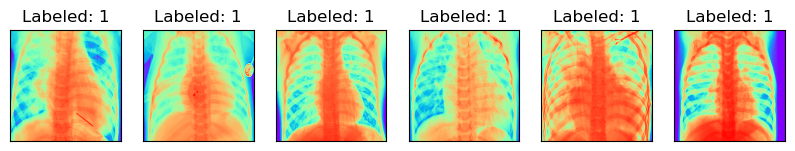

In [10]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap=plt.cm.rainbow)
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")

    n_samples_show -= 1

In [11]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main
C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main\models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main\models.py:77: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main\models.py:92: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
C:\Users\rjuya/.cache\to

In [12]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 2) # 2 classes
)
model = model.to('cuda')
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
)


In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss().to('cuda')

In [14]:
epochs = 16
model.train()
count = 1
loss_list = []
total_accuracy = []
model_path2 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/DeiT model.pt'
tic = time.time()
for epoch in range(epochs):
    correct = 0
    total_loss = []
    batch_size = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size+=1
        optimizer.zero_grad(set_to_none=True)
        output = model(data.to('cuda'))  # Forward pass, Data to GPU
        loss = loss_func(output, target.to('cuda')) #Labels to GPU
        loss.backward()  # Backward pass
        optimizer.step()
        total_loss.append(loss.item())
        train_pred = output.argmax(dim=1, keepdim=True)
        correct += train_pred.eq(target.to('cuda').view_as(train_pred)).sum().item()
    loss_list.append(sum(total_loss) / len(total_loss))
    accuracy = 100 * correct / 4077 # No. of training examples = 4077
    total_accuracy.append(accuracy)
    if ((100*(epoch+1))//epochs)//(count*10) >0 :
      count+=1
      print('Saving model with test loss of {:.3f}'.format(total_accuracy[-1]))
      torch.save(model.state_dict(), model_path2)
    print(f"Training [{100.0 * (epoch + 1) / epochs:.0f}%]\tLoss: {loss_list[-1]:.4f}\tAccuracy: {accuracy:.2f}%")


toc = time.time()

Training [6%]	Loss: 0.2652	Accuracy: 88.47%
Saving model with test loss of 92.911
Training [12%]	Loss: 0.1807	Accuracy: 92.91%
Training [19%]	Loss: 0.1611	Accuracy: 93.72%
Saving model with test loss of 94.285
Training [25%]	Loss: 0.1522	Accuracy: 94.29%
Saving model with test loss of 94.555
Training [31%]	Loss: 0.1468	Accuracy: 94.55%
Training [38%]	Loss: 0.1374	Accuracy: 94.97%
Saving model with test loss of 95.045
Training [44%]	Loss: 0.1337	Accuracy: 95.05%
Saving model with test loss of 95.413
Training [50%]	Loss: 0.1286	Accuracy: 95.41%
Training [56%]	Loss: 0.1189	Accuracy: 95.83%
Saving model with test loss of 95.585
Training [62%]	Loss: 0.1208	Accuracy: 95.58%
Training [69%]	Loss: 0.1132	Accuracy: 95.83%
Saving model with test loss of 95.855
Training [75%]	Loss: 0.1132	Accuracy: 95.85%
Saving model with test loss of 96.174
Training [81%]	Loss: 0.1057	Accuracy: 96.17%
Training [88%]	Loss: 0.1026	Accuracy: 96.37%
Saving model with test loss of 96.664
Training [94%]	Loss: 0.0968	A

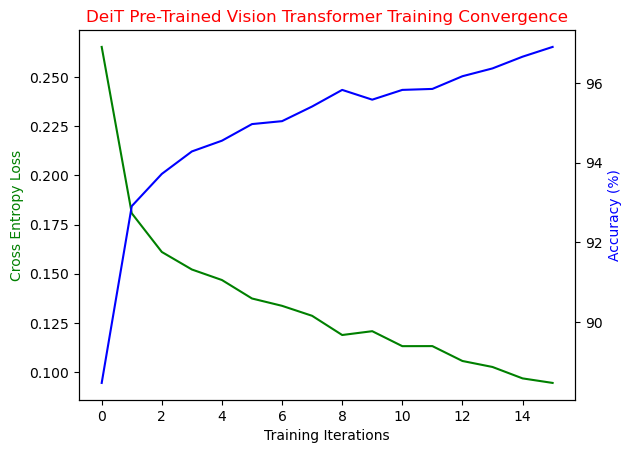

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(loss_list, 'g-')
ax2 = ax1.twinx()
ax2.plot(total_accuracy, 'b')
plt.title("DeiT Pre-Trained Vision Transformer Training Convergence", color='red')
ax1.set_xlabel("Training Iterations")
ax1.set_ylabel("Cross Entropy Loss", color='g')
ax2.set_ylabel("Accuracy (%)", color='b')
plt.show()

In [16]:
torch.save(model.state_dict(), model_path2)

In [20]:
model_temp = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)
model_temp.head = Sequential(
    Linear(n_inputs, 512),
    ReLU(),
    Dropout(0.3),
    Linear(512, 2) # 2 classes
)
model_temp.load_state_dict(torch.load(model_path2))
model_temp= model_temp.to('cuda')

Using cache found in C:\Users\rjuya/.cache\torch\hub\facebookresearch_deit_main


In [21]:
batch_size=1

model_temp.eval()
pred_targets = []
test_targets= []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_temp(data.to('cuda'))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        pred_targets.append(pred.item())
        test_targets.append(target.item())
        correct += pred.eq(target.to('cuda').view_as(pred)).sum().item()

        loss = loss_func(output, target.to('cuda'))
        total_loss.append(loss.item())

    print(f"Performance on test data:\n\tLoss: {sum(total_loss) / len(total_loss):.4f}\n\tAccuracy: {100 * correct / len(test_loader) / batch_size:.2f}%")
    print(test_targets)
    print(pred_targets)

Performance on test data:
	Loss: 0.1096
	Accuracy: 95.97%
[1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,

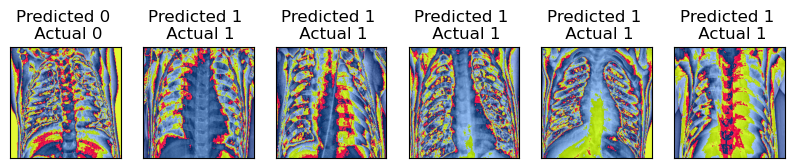

In [22]:
from PIL import Image
#abc
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_temp.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_temp(data.to('cuda')[0:1])
        if len(output.shape) == 1:
            output = output.reshape(3, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        test_targets2 = target.item()
        axes[count].imshow(torchvision.transforms.ToPILImage(mode='RGB')(data[0].squeeze()), cmap=plt.cm.rainbow)

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {} \n Actual {}".format(pred.item(),test_targets2))

        count += 1

In [23]:
time_taken = toc-tic

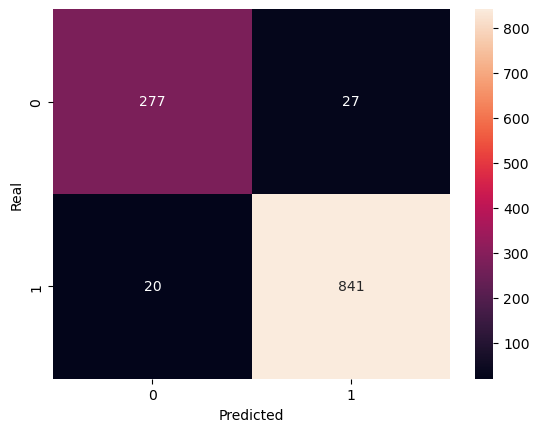

Time taken:  599.620598077774
Test size: 1165
Total Accuracy:  0.959656652360515
Total Precision:  0.9688940092165899
Total Recall:  0.9767711962833914
Total F1 Score:  0.9728166570271833
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       304
           1       0.97      0.98      0.97       861

    accuracy                           0.96      1165
   macro avg       0.95      0.94      0.95      1165
weighted avg       0.96      0.96      0.96      1165



In [24]:
val_diet = matrix_confusion(test_targets, pred_targets,time_taken)

In [25]:
outdiet = pd.DataFrame([val_diet],
                   index = ['DieT Model'],
                  columns=['Time','Accuracy','Precision','Recall','F1 score'])
outdiet.sort_values('Time')

,Time,Accuracy,Precision,Recall,F1 score
DieT Model,599.620598,0.959657,0.968894,0.976771,0.972817


In [26]:
import pickle

In [27]:
filepath1 = 'C:/Users/rjuya/OneDrive/Desktop/github stuff/EE5610/Project/Models/outputDieTModel.pickle'
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(outdiet, file)
    print("Data Stored Successfully")

Data Stored Successfully
